# Loading data to produce training data

In [3]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely 
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

## Download country boundaries

In [4]:
ISO = 'SWE' # "DEU" is the ISO code for Germany
ADM = 'ADM2' # Equivalent to administrative districts

# Query geoBoundaries
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(ISO, ADM))
dl_path = r.json()[0]['gjDownloadURL']

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()
with open(filename, 'w') as file:
    geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (290, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
103,Ornskoldsvik kommun,None,SWE-ADM2-3_0_0-B104,SWE,ADM2,"MULTIPOLYGON (((18.66024 63.01691, 18.66071 63..."
194,Eskilstuna kommun,None,SWE-ADM2-3_0_0-B195,SWE,ADM2,"MULTIPOLYGON (((16.70241 59.48771, 16.69775 59..."
213,Boxholm kommun,None,SWE-ADM2-3_0_0-B214,SWE,ADM2,"MULTIPOLYGON (((15.27765 58.13466, 15.27947 58..."


In this example, we visualize the adminstrative boundary for district **Sala kommun** using the GeoPandas `.plot()` function.

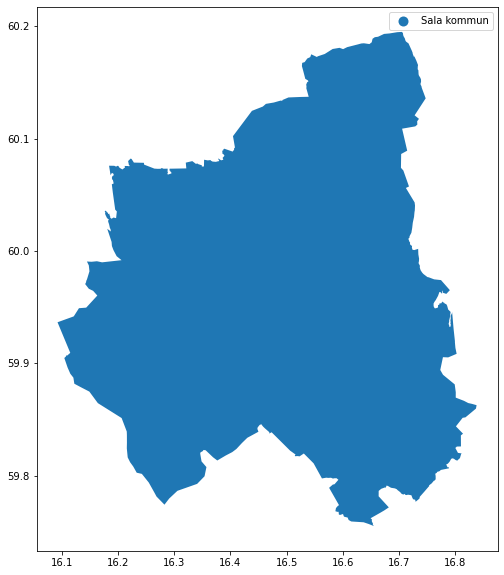

In [5]:
shape_name = 'Sala kommun'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

## Visualize Sentinel-2A Image

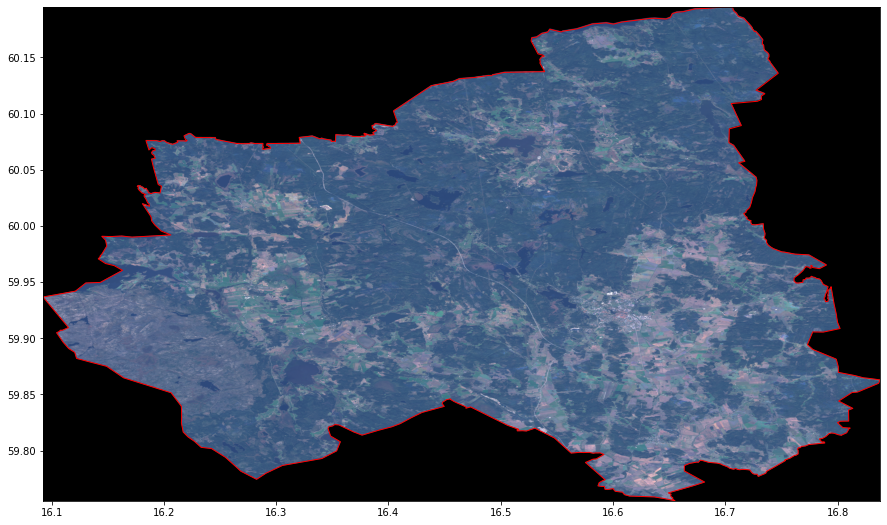

In [6]:
# Change this to your image file path
# tif_file = './drive/My Drive/Colab Notebooks/{}.tif'.format(shape_name) 
tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}.tif'.format(shape_name) 

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Generate 64x64 px GeoJSON Tiles

In [7]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.
    
    Args:
      image_file (str): Image file path (.tif) 
      output_file (str): Output file path (.geojson) 
      area_str (str): Name of the region
      size(int): Window size
    
    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles 
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : [], 'area' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
        for w in range(0, width, size):
            for h in range(0, height, size):
                # Create a Window of your desired size
                window = rio.windows.Window(h, w, size, size)
                # Get the georeferenced window bounds
                bbox = rio.windows.bounds(window, raster.transform)
                # Create a shapely geometry from the bounding box
                bbox = box(*bbox)

                # Create a unique id for each geometry
                uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

                # Update dictionary
                geo_dict['id'].append(uid)
                geo_dict['area'].append(area_str)
                geo_dict['geometry'].append(bbox)

                index += 1
                pbar.update(size*size)
    
    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 64x64 px across the Sala kommun Sentinel-2 satellite image.

In [8]:
# cwd = './drive/My Drive/Colab Notebooks/Land Use and Land Cover Classification/'
cwd = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/Land Use and Land Cover Classification'
output_file = cwd+'{}.geojson'.format(shape_name)
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/40630409 [00:00<?, ?it/s]

/Users/frape/miniforge3/envs/deep_wetlands/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (10010, 3)


,id,geometry,area
0,sala_kommun-0,"POLYGON ((16.09808 60.18937, 16.09808 60.19512...",Sala kommun
1,sala_kommun-1,"POLYGON ((16.10383 60.18937, 16.10383 60.19512...",Sala kommun
2,sala_kommun-2,"POLYGON ((16.10958 60.18937, 16.10958 60.19512...",Sala kommun


## Visualize 64x64 px Tiles

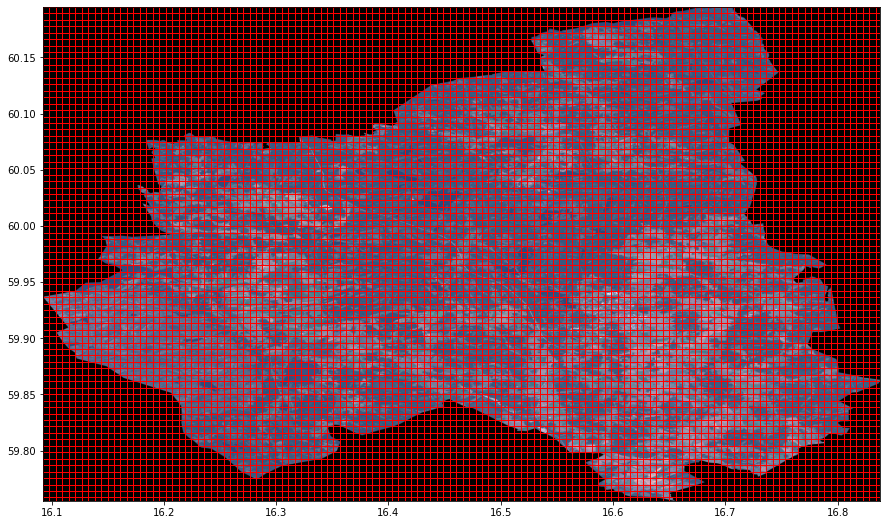

In [9]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Notice that the polygons are generated for empty (black) regions as well. Using our model to predict on blank regions seems computationally wasteful.

Instead, we can get the intersection between: 
- the Kreis Borken boundary polygon and 
- the 64 x 64 grid tiles.

To do this, we use GeoPandas `.sjoin()` function. We set parameter `op='within'` to indicate that we only want the tiles that lie within the district boundary.

[See  more information on GeoPandas sjoin operation here](https://geopandas.org/reference/geopandas.sjoin.html).


/Users/frape/miniforge3/envs/deep_wetlands/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/bk/sld6vd3d79dghhg7k3cxn1v80000gp/T/ipykernel_7147/2778194479.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


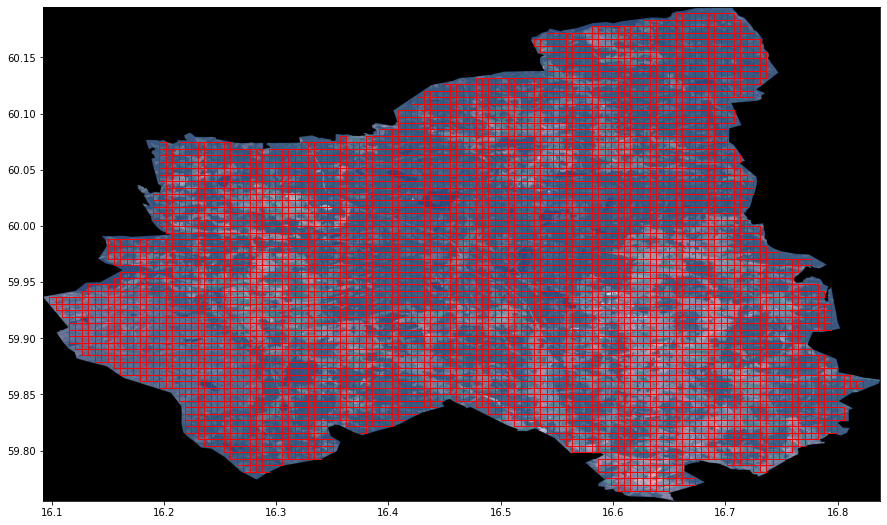

In [10]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualize Single Cropped Image

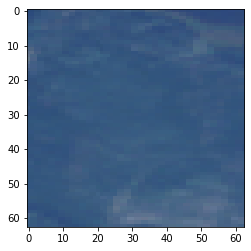

(3, 63, 63) <class 'numpy.ndarray'>


In [11]:
def show_crop(image, shape, title=''):
    """Crops an image based on the polygon shape.
    Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

    Args:
        image (str): Image file path (.tif) 
        shape (geometry): The tile with which to crop the image
        title(str): Image title
    """
  
    with rio.open(image) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
            :,
            np.min(x_nonzero):np.max(x_nonzero), 
            np.min(y_nonzero):np.max(y_nonzero)
        ]
        # Visualize image
        show(out_image, title=title)
        print(out_image.shape, type(out_image))

show_crop(tif_file, [tiles.iloc[0]['geometry']])

In [14]:
print(type(tiles), tiles.size)

<class 'geopandas.geodataframe.GeoDataFrame'> 50454
